# Pneumonia Diagnosis from Chest X-Ray Images using Deep Learning

## Downloading Dataset from Kaggle

Original Dataset Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia (I will not use this directly)

This dataset had **train, val, test** folders, each having **NORMAL, PNEUMONIA** sub folders.
- `train` folder: 5216 images in total
- `val` folder: 16 images in total
- `test` folder: 624 images in total

From this base dataset, its better to create a custom dataset where we have combined the images from `train` and `val` folders into the `train` folder itself. From this combined `train` folder, we can create the validation set using either a 80:20 or 85:15 split.

Such a dataset can be found here: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images (We will make use of this)

This has two main folders **train, test** with:
- 5232 images in `train` folder
- 624 images in `test` folder



In [23]:
!pip install kaggle

In [24]:
# Mount Google Drive (incase its not yet mounted)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note: If you have disconnected the runtime, you will have to mount Google Drive again, and go through the prompt it shows.

In [25]:
# Get Kaggle API Credentials from Drive
!mkdir ~/.kaggle
!ls -a ~
print('-----------')
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!ls ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
.   .bashrc  .config   .jupyter  .keras		.local	.nv	  .tmux.conf
..  .cache   .ipython  .kaggle	 .launchpadlib	.npm	.profile  .wget-hsts
-----------
kaggle.json


In [26]:
# Download the dataset to the local machine
# !kaggle datasets download paultimothymooney/chest-xray-pneumonia
!kaggle datasets download tolgadincer/labeled-chest-xray-images

100% 1.17G/1.17G [00:23<00:00, 69.7MB/s]
100% 1.17G/1.17G [00:23<00:00, 53.3MB/s]


In [27]:
# View where the dataset was downloaded
!ls
!pwd

drive  labeled-chest-xray-images.zip  sample_data
/content


The dataset was actually downloaded into the **Files** tab in the Left Hand Sidebar of Google Colab, as `chest-xray-pneumonia.zip`.

Now, unzip it using the linux `unzip` command.

In [28]:
# Unzip the dataset
# !unzip chest-xray-pneumonia.zip
!unzip labeled-chest-xray-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [29]:
# View the dataset location again :)
!pwd
!ls
!ls chest_xray
!ls chest_xray/train
!ls chest_xray/test

/content
chest_xray  drive  labeled-chest-xray-images.zip  sample_data
test  train
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


In [30]:
# Import required libraries (and import other libraries as & when you need them)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os

In [31]:
print(tf.__version__)
print(tf.test.gpu_device_name())

# Set a global seed for operations which rely on a random seed
tf.random.set_seed(42)
np.random.seed(42)

2.15.0
/device:GPU:0


## Load Dataset & EDA

In [32]:
TRAIN_DS_PATH = "chest_xray/train/"
TEST_DS_PATH = "chest_xray/test/"

IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32

In [33]:
# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DS_PATH,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.


In [34]:
# Load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DS_PATH,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
)

Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


In [35]:
# Load the test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DS_PATH,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE,
    seed = 42
)

Found 624 files belonging to 2 classes.


In [36]:
print(train_ds.class_names)
print(val_ds.class_names)
print(test_ds.class_names)
class_names = train_ds.class_names
print(class_names)

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


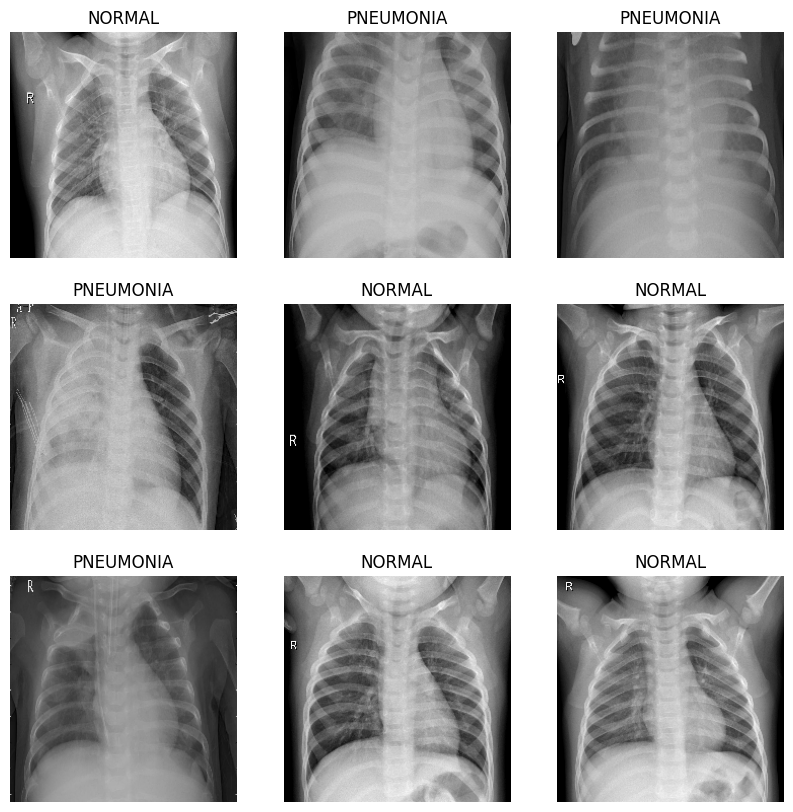

In [37]:
# Plot a few Chest X-Ray images
_ = plt.figure(figsize = (10, 10))
for (images_batch, labels_batch) in train_ds:
    for i in range(9):
        # print(labels_batch[i])
        # print(class_names[labels_batch[i]])
        plt.subplot(3, 3, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')
    break

In [38]:
# Get Distribution of classes in the subsets
def get_target_counts(ds_variable):
    distribution_var = [0, 0]
    for (images_batch, labels_batch) in ds_variable:
        for label in labels_batch:
            distribution_var[label] += 1
    return distribution_var

train_ds_distribution = get_target_counts(train_ds)
val_ds_distribution = get_target_counts(val_ds)
test_ds_distribution = get_target_counts(test_ds)

print(train_ds_distribution, sum(train_ds_distribution))
print(val_ds_distribution, sum(val_ds_distribution))
print(test_ds_distribution, sum(test_ds_distribution))

[1098, 3088] 4186
[251, 795] 1046
[234, 390] 624


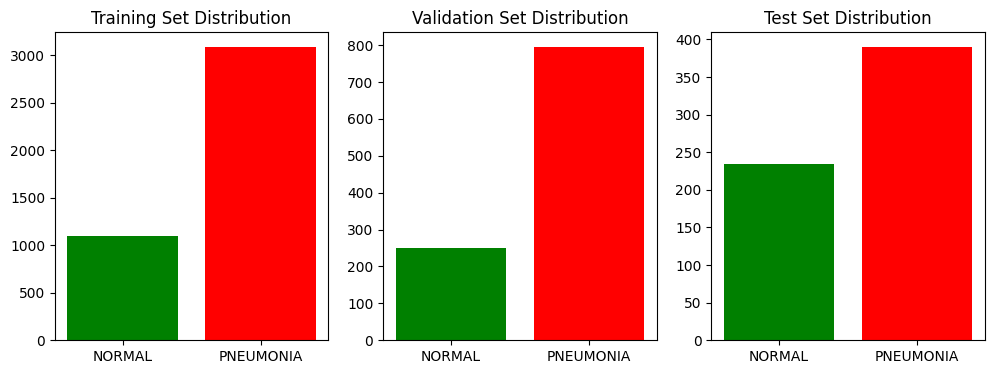

In [39]:
# Plot the distribution between the target classes in all the subsets

_ = plt.figure(figsize = (12, 4))

plt.subplot(1, 3, 1)
plt.title('Training Set Distribution')
plt.bar(class_names, train_ds_distribution, color = ['green', 'red'])

plt.subplot(1, 3, 2)
plt.title('Validation Set Distribution')
plt.bar(class_names, val_ds_distribution, color = ['green', 'red'])

plt.subplot(1, 3, 3)
plt.title('Test Set Distribution')
plt.bar(class_names, test_ds_distribution, color = ['green', 'red'])

plt.show()

This is a very imbalanced dataset. Refer to the below links to learn how to handle imbalanced dataset.


## Configure Dataset for Performance


In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

I will try to create several models, and choose the best performing model for inference purposes while building the web application.

- Custom CNN
- Transfer Learning (Both Feature Extraction & Fine Tuning) with:
    - VGG16
    - InceptionV3
    - ResNet50V2
    - EfficientNetB7

- For all these models, I will build a **Sequential Model** (EASY TO CODE).
    - The alternative approach is to use the *Functional API*, which is more flexible.
- In my opinion, Data Augmentation does not make sense for X-Ray Images, hence I will not do Data Augmentation.

- To simplify deployment, include the **`Rescaling`** layer as one of the layers of the sequential model.

In [41]:
# Get the target labels y (of the training dataset)
train_y = []
for img_batch, label_batch in train_ds:
    for label in label_batch:
        train_y.append(label.numpy())

print(train_y)

[1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 

In [42]:
# Now compute the class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights_list = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_y),
    y = train_y
)
print(class_weights_list)
# A dict is required for future purposes
class_weights = {
    0: class_weights_list[0],
    1: class_weights_list[1]
}
print(class_weights)

[1.90619308 0.67778497]
{0: 1.9061930783242258, 1: 0.6777849740932642}


Now, define some common functions, variables & utilities which will be use throughout the notebook.

We will have a common Fully Connected Network (Dense Layer) for all the models. Lets define that below.

In [43]:
# The common classification network (fully connected layers)
def get_classifier():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units = 1024, activation = 'relu'),
        tf.keras.layers.Dense(units = 512, activation = 'relu'),
        tf.keras.layers.Dropout(rate = 0.2),
        tf.keras.layers.Dense(units = 256, activation = 'relu'),
        tf.keras.layers.Dense(units = 128, activation = 'relu'),
        tf.keras.layers.Dropout(rate = 0.2),
    ])

def get_output_layer():
    # Output layer
    return tf.keras.layers.Dense(units = 1, activation = 'sigmoid')

In [44]:
# Define some Keras Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    min_delta = 1e-7,
    restore_best_weights = True
)

reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 2,
    factor = 0.2,
    cooldown = 0,
    verbose = 1,
    min_delta = 1e-7
)

Now, lets create the traditional `x_test` and `y_test` which will be used to evaluate the test set, and make predictions and obtain `y_pred` in order to plot confusion matrix, or print classification report.

In [45]:
# Create x_test, y_test
x_test = []
y_test = []

for img_batch, label_batch in test_ds:
    i = 0
    for img in img_batch:
        x_test.append(img)
        y_test.append(label_batch[i].numpy())
        i += 1

x_test = np.array(x_test)
y_test = np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(624, 224, 224, 3)
(624,)


Define a function which will compute the confusion matrix and plot it using *Seaborn's Heatmap*.

In [46]:
# Define a Function to compute & plot confusion matrix
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(y_true, y_pred):
    '''
    |y_true| = |y_pred|
    '''
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    sns.heatmap(cm, annot = True, fmt = '.0f')
    plt.show()

Define a function which will print the Classification Report, which has metrics like *Precision, Recall, F1-Score, Accuracy*.

In [47]:
# Define a Function to print the classification report
from sklearn.metrics import classification_report

def print_classification_report(y_true, y_pred):
    c_report = classification_report(y_true, y_pred)
    print(c_report)

Define a function to save a model to Google Drive.

In [48]:
import datetime

MODEL_SAVE_PATH_DRIVE = '/content/drive/MyDrive/Pneumonia_Diagnosis_Models'

def save_model_to_drive(model_var, model_name):
    current_timestamp = str(datetime.datetime.now()).replace(" ", "_")
    current_timestamp = current_timestamp[:current_timestamp.index('.')]
    save_path = f'{MODEL_SAVE_PATH_DRIVE}/{model_name}_{current_timestamp}'
    model_var.save(save_path)
    print('Model Saved at:', save_path)
    saved_model_pred = model_var.predict(test_ds)

    # Reconstruct and test the saved model
    reconstructed_model = tf.keras.models.load_model(save_path)
    try:
        recons_model_pred = reconstructed_model.predict(test_ds)
        np.testing.assert_allclose(
            saved_model_pred, recons_model_pred
        )
        print('Reconstruction of the model produces the same results!😎')
    except:
        print('Reconstruction of the model does not produce the same results!🤦‍♂️')

Define a function to evaluate a model on the test set and print the loss, accuracy.

In [49]:
# Function to evaluate a model on the test set
def evaluate_on_test_set(model_var, model_name):
    test_loss, test_acc = model_var.evaluate(test_ds)
    print(f'{model_name} Test Set Loss:', test_loss)
    print(f'{model_name} Test Set Accuracy:', test_acc)
    return (test_loss, test_acc)

Define a function to make predictions on the test set, and return a list of predicted class labels.

In [50]:
# Function to make predictions on the test set & return the list of predicted class labels
def make_pred_test_set(model_var):
    y_pred_proba = model_var.predict(x_test)
    y_pred = []
    for y_pred_proba_i in y_pred_proba:
        if y_pred_proba_i[0] > 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    print('First 10 elements of y_pred:', y_pred[:10])
    print('First 10 elements of y_test:', y_test[:10])
    return y_pred

In [51]:
# Define a function to plot the learning curves
def plot_learning_curves(history):
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = history.epoch

    _ = plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

In [52]:
# Some hyperparamters
MAX_EPOCHS = 25

## 1. Custom CNN

In [53]:
# Define a function to build and return the convolution base
def get_cnn_model():
    model = tf.keras.Sequential([
        # Input Layer
        tf.keras.Input(shape = IMG_SHAPE),
        # Rescaling layer (PREPROCESSING)
        tf.keras.layers.Rescaling(scale = 1.0/255.0),
        # Conv Block 1
        tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.MaxPool2D(),
        # Conv Block 2
        tf.keras.layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.SeparableConv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        # Conv Block 3
        tf.keras.layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.SeparableConv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(rate = 0.2),
        # Conv Block 4
        tf.keras.layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.SeparableConv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(rate = 0.2),
        # Conv Block 5
        tf.keras.layers.SeparableConv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.SeparableConv2D(filters = 256, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(rate = 0.2),
        # Flatten
        tf.keras.layers.Flatten(),
        # Fully Connected Layers
        get_classifier(),
        # Output layer
        get_output_layer()
    ])
    return model

In [54]:
cnn_model = get_cnn_model()
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 separable_conv2d (Separabl  (None, 112, 112, 32)      688       
 eConv2D)                                                        
                                                                 
 separable_conv2d_1 (Separa  (None, 112, 112, 32)     

In [55]:
# Compile the model
cnn_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [56]:
# Train the model
cnn_history = cnn_model.fit(
    train_ds,
    epochs = MAX_EPOCHS,
    validation_data = val_ds,
    callbacks = [early_stopping, reduce_lr_on_plateau],
    class_weight = class_weights
)

Epoch 1/25
131/131 [==============================] - 39s 191ms/step - loss: 0.2930 - accuracy: 0.8567 - val_loss: 0.5904 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 15s 115ms/step - loss: 0.1421 - accuracy: 0.9489 - val_loss: 2.7593 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - ETA: 0s - loss: 0.1128 - accuracy: 0.9534
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
131/131 [==============================] - 16s 121ms/step - loss: 0.1128 - accuracy: 0.9534 - val_loss: 2.9001 - val_accuracy: 0.7600 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 15s 118ms/step - loss: 0.0832 - accuracy: 0.9608 - val_loss: 3.4203 - val_accuracy: 0.7600 - lr: 2.0000e-04
Epoch 5/25
131/131 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9806
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
131/131 [====================

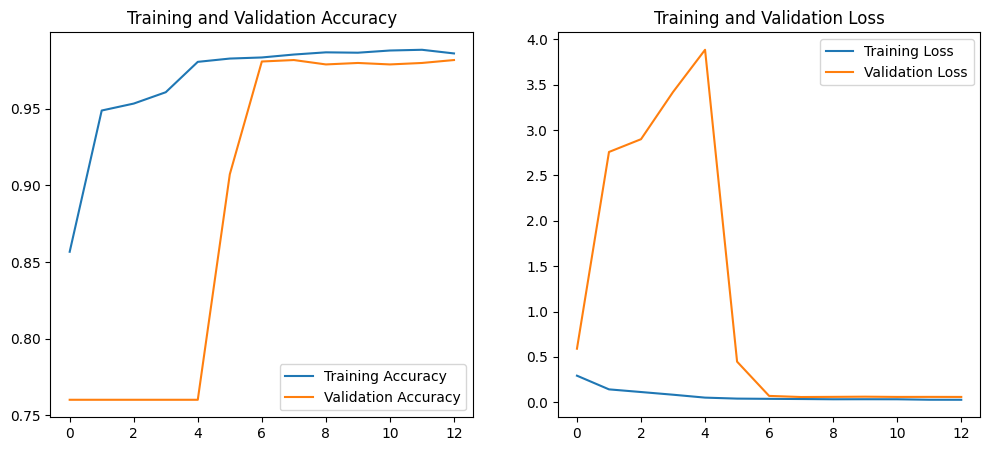

In [57]:
plot_learning_curves(cnn_history)

In [58]:
# Evaluate the test set results
evaluate_on_test_set(cnn_model, 'CNN')

20/20 [==============================] - 1s 52ms/step - loss: 0.9134 - accuracy: 0.8574
CNN Test Set Loss: 0.913408637046814
CNN Test Set Accuracy: 0.8573718070983887


(0.913408637046814, 0.8573718070983887)

In [59]:
# Make predictions on test set
cnn_y_pred = make_pred_test_set(cnn_model)

20/20 [==============================] - 1s 23ms/step
First 10 elements of y_pred: [1 1 1 1 1 1 0 1 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]


[[147  87]
 [  2 388]]


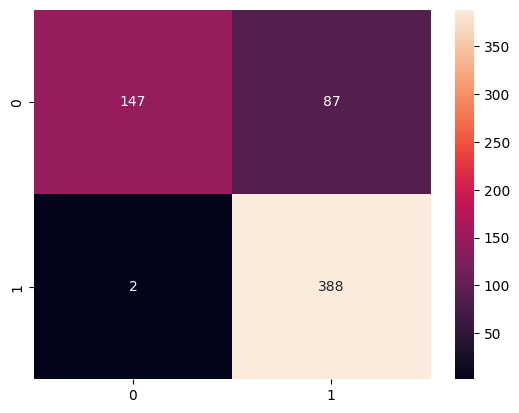

In [60]:
# Confusion Matrix
show_confusion_matrix(y_test, cnn_y_pred)

In [61]:
# Compute Metrics (Precision, Recall, F1-Score) - Classification Report
print_classification_report(y_test, cnn_y_pred)

              precision    recall  f1-score   support

           0       0.99      0.63      0.77       234
           1       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [62]:
# Save this CNN
save_model_to_drive(cnn_model, 'cnn_model')

Model Saved at: /content/drive/MyDrive/Pneumonia_Diagnosis_Models/cnn_model_2024-03-13_02:13:59
20/20 [==============================] - 1s 24ms/step
Reconstruction of the model produces the same results!😎


In [63]:
!ls /content/drive/MyDrive/Pneumonia_Diagnosis_Models

cnn_model_2024-03-13_02:13:59


## 2. Transfer Learning with VGG16 (Feature Extraction)

In [64]:
# Get VGG16 Pretrained Model
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(
    include_top = False,
    weights = 'imagenet',
    input_shape = IMG_SHAPE
)

58889256/58889256 [==============================] - 1s 0us/step


In [65]:
# Freeze the Conv Base (For Feature Extraction)
vgg16_conv_base.trainable = False

vgg16_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [66]:
# Define the entire model

# Input Layer
vgg16_inputs = tf.keras.layers.Input(shape = IMG_SHAPE)

# Preprocessing layer of VGG16
vgg16_x = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name = 'preprocess_input')(vgg16_inputs)

vgg16_x = vgg16_conv_base(vgg16_x)

vgg16_x = tf.keras.layers.Flatten()(vgg16_x)

vgg16_x = get_classifier()(vgg16_x)

vgg16_output_layer = get_output_layer()
vgg16_outputs = vgg16_output_layer(vgg16_x)

vgg16_tl_model = tf.keras.Model(inputs = vgg16_inputs, outputs = vgg16_outputs)

vgg16_tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 preprocess_input (Lambda)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 sequential_2 (Sequential)   (None, 128)               26380160  
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 41094977 (156.76 MB)
Trainable params: 26380289

In [67]:
# Compile the model
vgg16_tl_model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [68]:
# Train the model
vgg16_tl_model_history = vgg16_tl_model.fit(
    train_ds,
    epochs = MAX_EPOCHS,
    validation_data = val_ds,
    callbacks = [early_stopping, reduce_lr_on_plateau],
    class_weight = class_weights
)

Epoch 1/25
131/131 [==============================] - 44s 264ms/step - loss: 2.2908 - accuracy: 0.9095 - val_loss: 0.0997 - val_accuracy: 0.9780 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 22s 169ms/step - loss: 0.1887 - accuracy: 0.9689 - val_loss: 0.3660 - val_accuracy: 0.9446 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9795
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
131/131 [==============================] - 23s 175ms/step - loss: 0.0963 - accuracy: 0.9795 - val_loss: 0.1400 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 23s 173ms/step - loss: 0.0285 - accuracy: 0.9907 - val_loss: 0.0665 - val_accuracy: 0.9857 - lr: 2.0000e-04
Epoch 5/25
131/131 [==============================] - 23s 178ms/step - loss: 0.0113 - accuracy: 0.9969 - val_loss: 0.0568 - val_accuracy: 0.9866 - lr: 2.0000e-04
Epoch 6/25
131/131 [====================

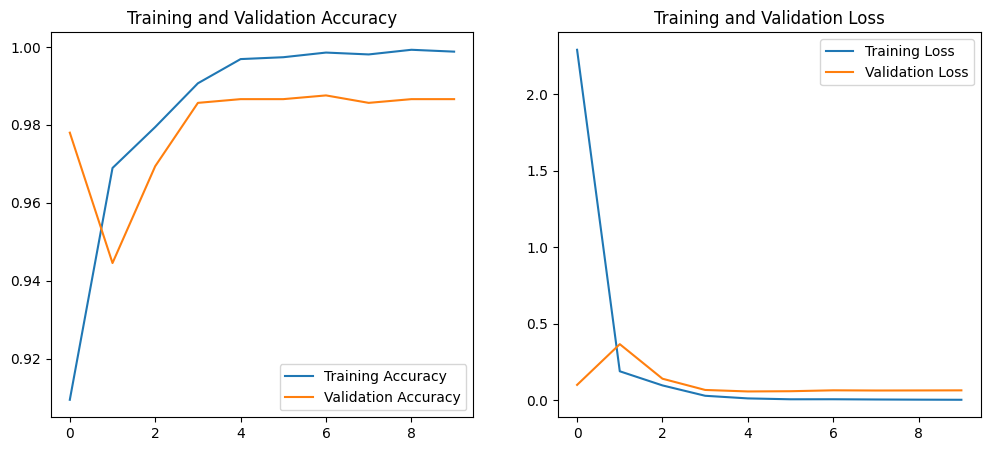

In [69]:
plot_learning_curves(vgg16_tl_model_history)

In [70]:
# Evaluate the test set results
evaluate_on_test_set(vgg16_tl_model, 'VGG16 Feature Extraction')

20/20 [==============================] - 7s 352ms/step - loss: 1.1318 - accuracy: 0.8894
VGG16 Feature Extraction Test Set Loss: 1.1318403482437134
VGG16 Feature Extraction Test Set Accuracy: 0.8894230723381042


(1.1318403482437134, 0.8894230723381042)

In [71]:
# Make predictions on test set
vgg16_feature_extraction_y_pred = make_pred_test_set(vgg16_tl_model)

20/20 [==============================] - 3s 134ms/step
First 10 elements of y_pred: [1 1 1 1 1 0 0 1 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]


[[167  67]
 [  2 388]]


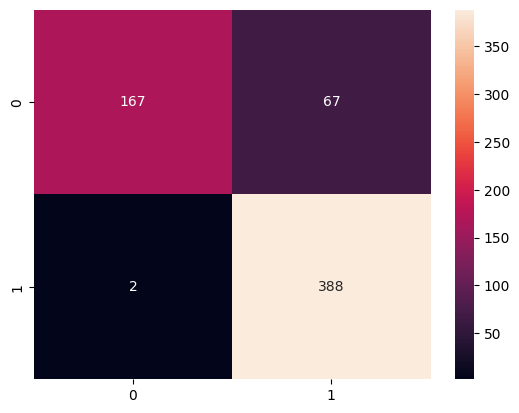

In [72]:
# Confusion Matrix
show_confusion_matrix(y_test, vgg16_feature_extraction_y_pred)

In [73]:
# Compute Metrics (Precision, Recall, F1-Score) - Classification Report
print_classification_report(y_test, vgg16_feature_extraction_y_pred)

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       234
           1       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



In [74]:
# Save this model
save_model_to_drive(vgg16_tl_model, 'vgg16_feature_extraction')

Model Saved at: /content/drive/MyDrive/Pneumonia_Diagnosis_Models/vgg16_feature_extraction_2024-03-13_02:21:03
20/20 [==============================] - 3s 127ms/step
Reconstruction of the model produces the same results!😎


In [75]:
!ls /content/drive/MyDrive/Pneumonia_Diagnosis_Models

cnn_model_2024-03-13_02:13:59  vgg16_feature_extraction_2024-03-13_02:21:03


## 3. Transfer Learning with VGG16 (Fine Tuning)

In [76]:
for layer in vgg16_conv_base.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [77]:
# Freeze only a few layers (Upto Block3)
vgg16_conv_base.trainable = True
fine_tune_at = 11
for layer in vgg16_conv_base.layers[:fine_tune_at]:
    layer.trainable = False

In [78]:
for layer in vgg16_conv_base.layers:
    print(layer.name, layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [79]:
vgg16_tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 preprocess_input (Lambda)   (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 sequential_2 (Sequential)   (None, 128)               26380160  
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 41094977 (156.76 MB)
Trainable params: 39359489

In [80]:
# Compile the model
vgg16_tl_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [81]:
vgg16_tl_model_history_fine_tuning = vgg16_tl_model.fit(
    train_ds,
    epochs = MAX_EPOCHS,
    validation_data = val_ds,
    callbacks = [early_stopping, reduce_lr_on_plateau],
    class_weight = class_weights
)

Epoch 1/25
131/131 [==============================] - 42s 274ms/step - loss: 0.0095 - accuracy: 0.9967 - val_loss: 0.0555 - val_accuracy: 0.9885 - lr: 1.0000e-06
Epoch 2/25
131/131 [==============================] - 32s 243ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.0548 - val_accuracy: 0.9876 - lr: 1.0000e-06
Epoch 3/25
131/131 [==============================] - 32s 243ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0537 - val_accuracy: 0.9885 - lr: 1.0000e-06
Epoch 4/25
131/131 [==============================] - 32s 244ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0552 - val_accuracy: 0.9876 - lr: 1.0000e-06
Epoch 5/25
131/131 [==============================] - 32s 247ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0518 - val_accuracy: 0.9876 - lr: 1.0000e-06
Epoch 6/25
131/131 [==============================] - 32s 247ms/step - loss: 0.0028 - accuracy: 0.9990 - val_loss: 0.0506 - val_accuracy: 0.9885 - lr: 1.0000e-06
Epoch 7/25
131/131 [========

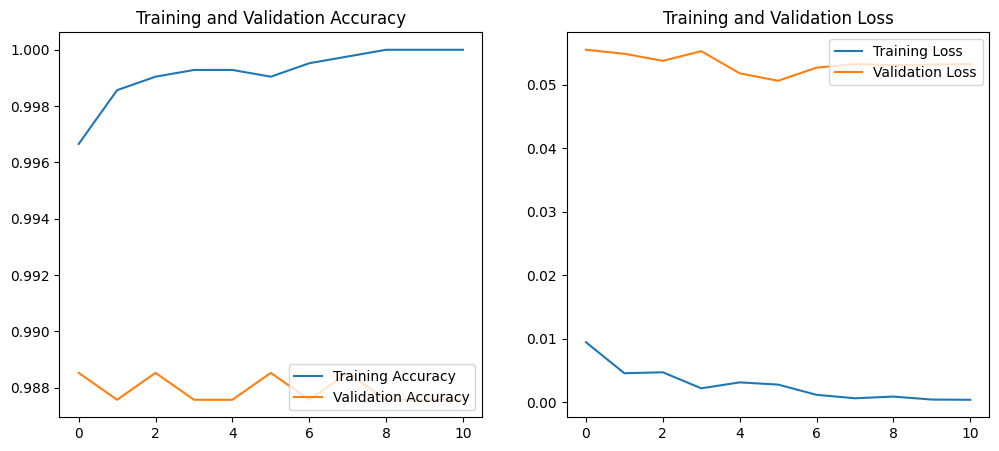

In [82]:
plot_learning_curves(vgg16_tl_model_history_fine_tuning)

In [83]:
# Evaluate the test set results
evaluate_on_test_set(vgg16_tl_model, 'VGG16 FINE TUNING')

20/20 [==============================] - 3s 125ms/step - loss: 1.1949 - accuracy: 0.8926
VGG16 FINE TUNING Test Set Loss: 1.194949746131897
VGG16 FINE TUNING Test Set Accuracy: 0.8926281929016113


(1.194949746131897, 0.8926281929016113)

In [84]:
# Make predictions on test set
vgg16_fine_tune_y_pred = make_pred_test_set(vgg16_tl_model)

20/20 [==============================] - 3s 127ms/step
First 10 elements of y_pred: [1 1 1 1 1 0 0 1 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]


[[169  65]
 [  2 388]]


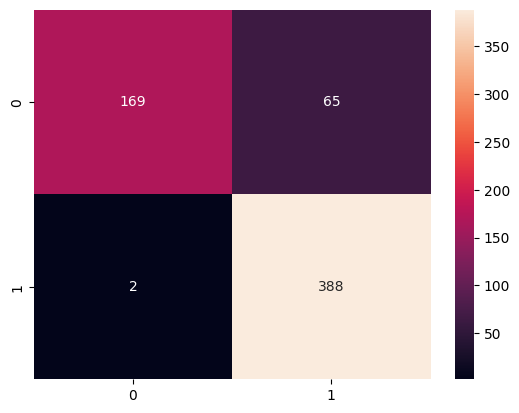

In [85]:
# Confusion Matrix
show_confusion_matrix(y_test, vgg16_fine_tune_y_pred)

In [86]:
# Compute Metrics (Precision, Recall, F1-Score) - Classification Report
print_classification_report(y_test, vgg16_fine_tune_y_pred)

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       234
           1       0.86      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.88       624
weighted avg       0.91      0.89      0.89       624



In [87]:
# Save this model
save_model_to_drive(vgg16_tl_model, 'vgg16_fine_tuning')

Model Saved at: /content/drive/MyDrive/Pneumonia_Diagnosis_Models/vgg16_fine_tuning_2024-03-13_02:28:46
20/20 [==============================] - 3s 129ms/step
Reconstruction of the model produces the same results!😎


In [88]:
!ls /content/drive/MyDrive/Pneumonia_Diagnosis_Models

cnn_model_2024-03-13_02:13:59		      vgg16_fine_tuning_2024-03-13_02:28:46
vgg16_feature_extraction_2024-03-13_02:21:03


## 4. Transfer Learning with ResNet152V2 (Feature Extraction)

In [89]:
# Get the ResNet152V2 Convolution Base
resnet_conv_base = tf.keras.applications.resnet_v2.ResNet152V2(
    weights = "imagenet",
    input_shape = IMG_SHAPE,
    include_top = False
)

234545216/234545216 [==============================] - 3s 0us/step


In [90]:
# Freeze the base model
resnet_conv_base.trainable = False

In [91]:

# Input Layer
resnet_inputs = tf.keras.layers.Input(shape = IMG_SHAPE)

# Preprocessing layer of ResNet152V2
resnet_x = tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input, name = 'resnet_preprocess_input')(resnet_inputs)

resnet_x = resnet_conv_base(resnet_x, training = False)

# resnet_x = tf.keras.layers.Flatten()(resnet_x)
resnet_x = tf.keras.layers.GlobalAveragePooling2D()(resnet_x)

resnet_x = get_classifier()(resnet_x)

resnet_output_layer = get_output_layer()
resnet_outputs = resnet_output_layer(resnet_x)

resnet_tl_model = tf.keras.Model(resnet_inputs, resnet_outputs)

resnet_tl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet_preprocess_input (L  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 sequential_3 (Sequential)   (None, 128)               2787200   
                                                                 
 dense_14 (Dense)            (None, 1)                 129 

In [92]:
# Compile
resnet_tl_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [93]:
# Train the model
resnet_tl_model_history = resnet_tl_model.fit(
    train_ds,
    epochs = MAX_EPOCHS,
    validation_data = val_ds,
    callbacks = [early_stopping, reduce_lr_on_plateau],
    class_weight = class_weights
)

Epoch 1/25
131/131 [==============================] - 60s 353ms/step - loss: 0.4803 - accuracy: 0.7575 - val_loss: 0.2601 - val_accuracy: 0.9350 - lr: 1.0000e-05
Epoch 2/25
131/131 [==============================] - 40s 308ms/step - loss: 0.2342 - accuracy: 0.9271 - val_loss: 0.1513 - val_accuracy: 0.9455 - lr: 1.0000e-05
Epoch 3/25
131/131 [==============================] - 38s 290ms/step - loss: 0.1700 - accuracy: 0.9419 - val_loss: 0.1100 - val_accuracy: 0.9579 - lr: 1.0000e-05
Epoch 4/25
131/131 [==============================] - 38s 287ms/step - loss: 0.1486 - accuracy: 0.9482 - val_loss: 0.0964 - val_accuracy: 0.9675 - lr: 1.0000e-05
Epoch 5/25
131/131 [==============================] - 38s 289ms/step - loss: 0.1302 - accuracy: 0.9510 - val_loss: 0.0941 - val_accuracy: 0.9646 - lr: 1.0000e-05
Epoch 6/25
131/131 [==============================] - 38s 287ms/step - loss: 0.1173 - accuracy: 0.9575 - val_loss: 0.0869 - val_accuracy: 0.9704 - lr: 1.0000e-05
Epoch 7/25
131/131 [========

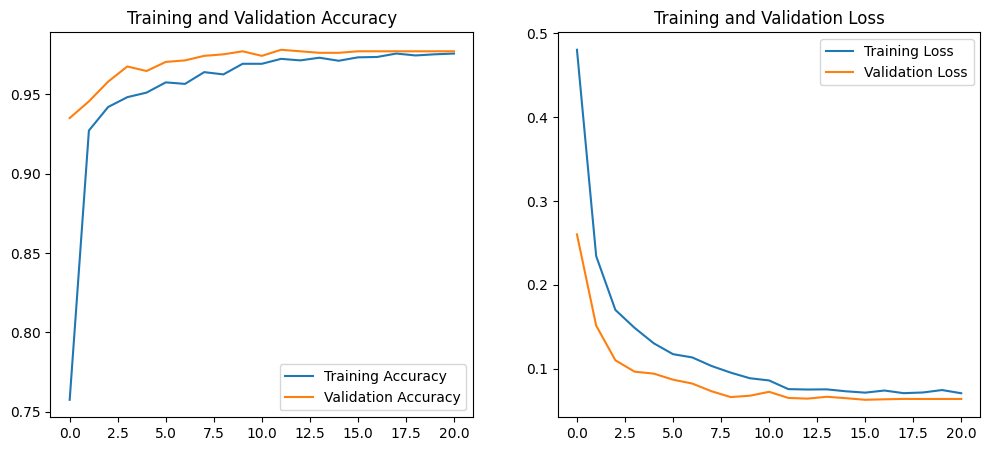

In [94]:
plot_learning_curves(resnet_tl_model_history)

In [95]:
# Evaluate the test set results
evaluate_on_test_set(resnet_tl_model, 'ResNet152V2')

20/20 [==============================] - 6s 313ms/step - loss: 0.3071 - accuracy: 0.8958
ResNet152V2 Test Set Loss: 0.3070783317089081
ResNet152V2 Test Set Accuracy: 0.8958333134651184


(0.3070783317089081, 0.8958333134651184)

In [96]:
# Make predictions on test set
resnet_y_pred = make_pred_test_set(resnet_tl_model)

20/20 [==============================] - 7s 223ms/step
First 10 elements of y_pred: [1 1 1 1 1 1 0 0 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]


[[176  58]
 [  7 383]]


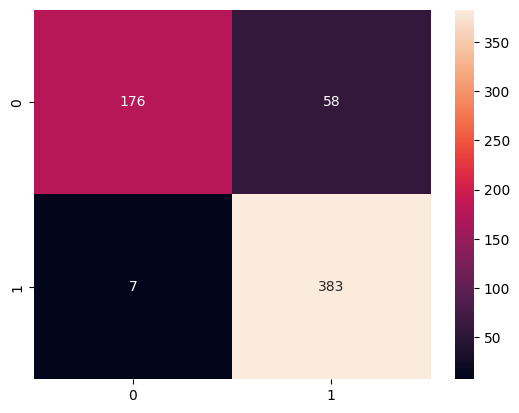

In [97]:
# Confusion Matrix
show_confusion_matrix(y_test, resnet_y_pred)

In [98]:
# Compute Metrics (Precision, Recall, F1-Score) - Classification Report
print_classification_report(y_test, resnet_y_pred)

              precision    recall  f1-score   support

           0       0.96      0.75      0.84       234
           1       0.87      0.98      0.92       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.88       624
weighted avg       0.90      0.90      0.89       624



In [99]:
# Save this CNN
save_model_to_drive(resnet_tl_model, 'resnet152v2_feature_extraction')

Model Saved at: /content/drive/MyDrive/Pneumonia_Diagnosis_Models/resnet152v2_feature_extraction_2024-03-13_02:43:42
20/20 [==============================] - 7s 220ms/step
Reconstruction of the model produces the same results!😎


In [100]:
!ls /content/drive/MyDrive/Pneumonia_Diagnosis_Models

cnn_model_2024-03-13_02:13:59			    vgg16_feature_extraction_2024-03-13_02:21:03
resnet152v2_feature_extraction_2024-03-13_02:43:42  vgg16_fine_tuning_2024-03-13_02:28:46


## 5. Transfer Learning with ResNet152V2 (Fine Tuning)

In [101]:
resnet_conv_base.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [102]:
# Unfreeze some layers

resnet_conv_base.trainable = True

for layer in resnet_conv_base.layers:
    if ("conv5" not in layer.name):
        layer.trainable = False

cnt_frozen, cnt_unfrozen = 0, 0
for layer in resnet_conv_base.layers:
    if layer.trainable:
        cnt_unfrozen += 1
    else:
        cnt_frozen += 1

print('Frozen Layers Count  :', cnt_frozen)
print('UnFrozen Layers Count:', cnt_unfrozen)

Frozen Layers Count  : 530
UnFrozen Layers Count: 34


In [103]:
resnet_tl_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet_preprocess_input (L  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 sequential_3 (Sequential)   (None, 128)               2787200   
                                                                 
 dense_14 (Dense)            (None, 1)                 129 

In [104]:
# Compile the model
resnet_tl_model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [105]:
# Fine Tune
resnet_tl_model_history_fine_tuning = resnet_tl_model.fit(
    train_ds,
    epochs = MAX_EPOCHS,
    validation_data = val_ds,
    callbacks = [early_stopping, reduce_lr_on_plateau],
    class_weight = class_weights
)

Epoch 1/25
131/131 [==============================] - 65s 361ms/step - loss: 0.0693 - accuracy: 0.9759 - val_loss: 0.0732 - val_accuracy: 0.9732 - lr: 1.0000e-06
Epoch 2/25
131/131 [==============================] - 43s 329ms/step - loss: 0.0592 - accuracy: 0.9790 - val_loss: 0.0655 - val_accuracy: 0.9771 - lr: 1.0000e-06
Epoch 3/25
131/131 [==============================] - 43s 325ms/step - loss: 0.0488 - accuracy: 0.9823 - val_loss: 0.0657 - val_accuracy: 0.9761 - lr: 1.0000e-06
Epoch 4/25
131/131 [==============================] - 43s 327ms/step - loss: 0.0393 - accuracy: 0.9871 - val_loss: 0.0533 - val_accuracy: 0.9799 - lr: 1.0000e-06
Epoch 5/25
131/131 [==============================] - 43s 329ms/step - loss: 0.0307 - accuracy: 0.9892 - val_loss: 0.0512 - val_accuracy: 0.9799 - lr: 1.0000e-06
Epoch 6/25
131/131 [==============================] - 43s 326ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0515 - val_accuracy: 0.9818 - lr: 1.0000e-06
Epoch 7/25
131/131 [========

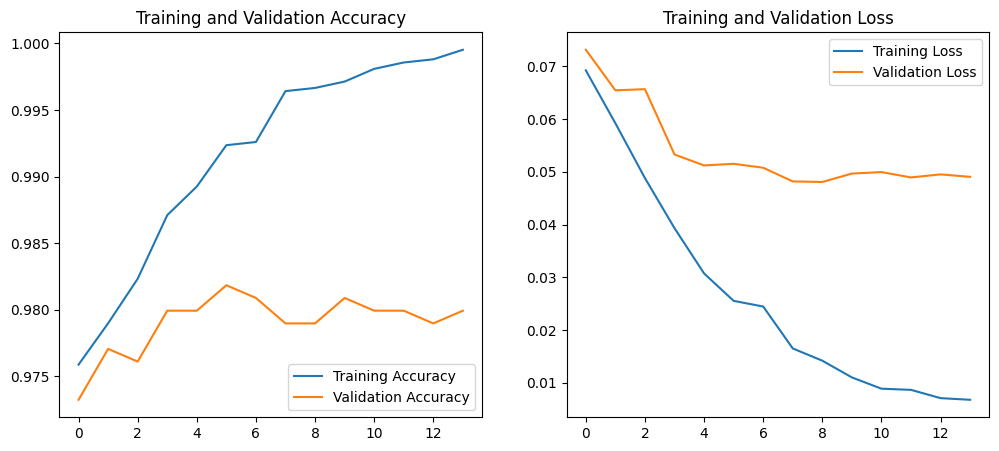

In [106]:
plot_learning_curves(resnet_tl_model_history_fine_tuning)

In [107]:
# Evaluate the test set results
evaluate_on_test_set(resnet_tl_model, 'ResNet152V2 Fine Tuning')

20/20 [==============================] - 5s 229ms/step - loss: 0.4883 - accuracy: 0.8894
ResNet152V2 Fine Tuning Test Set Loss: 0.4882843792438507
ResNet152V2 Fine Tuning Test Set Accuracy: 0.8894230723381042


(0.4882843792438507, 0.8894230723381042)

In [108]:
# Make predictions on test set
resnet_fine_tune_y_pred = make_pred_test_set(resnet_tl_model)

20/20 [==============================] - 7s 224ms/step
First 10 elements of y_pred: [1 1 1 1 1 1 0 0 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]


[[168  66]
 [  3 387]]


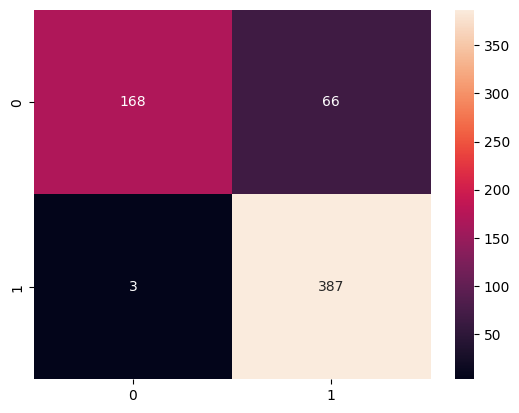

In [109]:
# Confusion Matrix
show_confusion_matrix(y_test, resnet_fine_tune_y_pred)

In [110]:
# Compute Metrics (Precision, Recall, F1-Score) - Classification Report
print_classification_report(y_test, resnet_fine_tune_y_pred)

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       234
           1       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.86      0.87       624
weighted avg       0.90      0.89      0.88       624



In [111]:
# Save this CNN
save_model_to_drive(resnet_tl_model, 'resnet152v2_fine_tune')

Model Saved at: /content/drive/MyDrive/Pneumonia_Diagnosis_Models/resnet152v2_fine_tune_2024-03-13_03:02:22
20/20 [==============================] - 8s 218ms/step
Reconstruction of the model produces the same results!😎


In [112]:
!ls /content/drive/MyDrive/Pneumonia_Diagnosis_Models

cnn_model_2024-03-13_02:13:59			    vgg16_feature_extraction_2024-03-13_02:21:03
resnet152v2_feature_extraction_2024-03-13_02:43:42  vgg16_fine_tuning_2024-03-13_02:28:46
resnet152v2_fine_tune_2024-03-13_03:02:22


## Print a summary report of all saved model

For simplicity, I am choosing accuracy as the performance metric. In practical cases, AUC-ROC Curve and Classification Report Metrics might be used inplace of accuracy.

In [114]:
!ls /content/drive/MyDrive/Pneumonia_Diagnosis_Models

cnn_model_2024-03-13_02:13:59			    vgg16_feature_extraction_2024-03-13_02:21:03
resnet152v2_feature_extraction_2024-03-13_02:43:42  vgg16_fine_tuning_2024-03-13_02:28:46
resnet152v2_fine_tune_2024-03-13_03:02:22


Note: Some models previously were trained on 200x200 px images in constrast to latest ones on 224x224 px images.

In [115]:
import os

BASE_PATH = '/content/drive/MyDrive/Pneumonia_Diagnosis_Models'
models = os.listdir(BASE_PATH)

data = {
    'Model Name': [],
    'Train Accuracy': [],
    'Train Loss': [],
    'Validation Accuracy': [],
    'Validation Loss': [],
    'Test Accuracy': [],
    'Test Loss': [],
    'Precision(NORMAL)': [],
    'Recall(NORMAL)': [],
    'F1Score(NORMAL)': [],
    'Support(NORMAL)': [],
    'Precision(PNEUMONIA)': [],
    'Recall(PNEUMONIA)': [],
    'F1Score(PNEUMONIA)': [],
    'Support(PNEUMONIA)': [],
    'Macro Avg Precision': [],
    'Macro Avg Recall': [],
    'Macro Avg F1Score': [],
    'Macro Avg Support': [],
    'Weighted Avg Precision': [],
    'Weighted Avg Recall': [],
    'Weighted Avg F1Score': [],
    'Weighted Avg Support': [],
}

for model_path in models:
    try:
        model = tf.keras.models.load_model(os.path.join(BASE_PATH, model_path))
        train_loss, train_acc = model.evaluate(train_ds)
        val_loss, val_acc = model.evaluate(val_ds)
        test_loss, test_acc = model.evaluate(test_ds)
        report = classification_report(y_test, make_pred_test_set(model), output_dict = True)
        data['Model Name'].append(model_path)
        data['Train Accuracy'].append(train_acc)
        data['Train Loss'].append(train_loss)
        data['Validation Accuracy'].append(val_acc)
        data['Validation Loss'].append(val_loss)
        data['Test Accuracy'].append(test_acc)
        data['Test Loss'].append(test_loss)
        data['Precision(NORMAL)'].append(report['0']['precision'])
        data['Recall(NORMAL)'].append(report['0']['recall'])
        data['F1Score(NORMAL)'].append(report['0']['f1-score'])
        data['Support(NORMAL)'].append(report['0']['support'])
        data['Precision(PNEUMONIA)'].append(report['1']['precision'])
        data['Recall(PNEUMONIA)'].append(report['1']['recall'])
        data['F1Score(PNEUMONIA)'].append(report['1']['f1-score'])
        data['Support(PNEUMONIA)'].append(report['1']['support'])
        data['Macro Avg Precision'].append(report['macro avg']['precision'])
        data['Macro Avg Recall'].append(report['macro avg']['recall'])
        data['Macro Avg F1Score'].append(report['macro avg']['f1-score'])
        data['Macro Avg Support'].append(report['macro avg']['support'])
        data['Weighted Avg Precision'].append(report['weighted avg']['precision'])
        data['Weighted Avg Recall'].append(report['weighted avg']['recall'])
        data['Weighted Avg F1Score'].append(report['weighted avg']['f1-score'])
        data['Weighted Avg Support'].append(report['weighted avg']['support'])
    except:
        None

20/20 [==============================] - 1s 23ms/step
First 10 elements of y_pred: [1 1 1 1 1 1 0 1 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]
20/20 [==============================] - 3s 127ms/step
First 10 elements of y_pred: [1 1 1 1 1 0 0 1 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]
20/20 [==============================] - 3s 133ms/step
First 10 elements of y_pred: [1 1 1 1 1 0 0 1 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]
20/20 [==============================] - 8s 223ms/step
First 10 elements of y_pred: [1 1 1 1 1 1 0 0 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]
20/20 [==============================] - 7s 225ms/step
First 10 elements of y_pred: [1 1 1 1 1 1 0 0 0 1]
First 10 elements of y_test: [1 0 1 1 0 0 0 0 0 1]


In [116]:
df = pd.DataFrame(data)

df.to_excel(os.path.join(BASE_PATH, 'Summary.xlsx'), index = False)